In [1]:
import seaborn as sns
sns.set()

In [29]:
import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

import more_itertools as mit

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.metrics import roc_auc_score, precision_recall_curve

In [3]:
! pip install -e ../../

Obtaining file:///home/didi/Documents/fake-image-detection
  Found existing installation: src 0.0.1
    Uninstalling src-0.0.1:
      Successfully uninstalled src-0.0.1
  Running setup.py develop for src


In [4]:
from src.features.url_classification import classifier_LICA, classifier_DFR

In [5]:
lica_clf = classifier_LICA.LICA()
dfr_clf = classifier_DFR.DFR()

In [6]:
def my_tokenizer(doc):
    return doc

In [7]:
DIR = '../../data/processed'

In [15]:
crawls = glob.glob('{}/media_*.csv'.format(DIR))
last_crawl = sorted(crawls)[-1]
df = pd.read_csv(last_crawl)

In [16]:
df.columns

Index(['claim', 'descriptions', 'img', 'label', 'legal_page_urls', 'page_urls',
       'text_on_image', 'url_caption', 'known_urls', 'true_perc', 'false_perc',
       'mixed_perc', 'invalid_count', 'known_count', 'total_count'],
      dtype='object')

In [17]:
df.legal_page_urls = df.legal_page_urls.apply(lambda x: [y.strip(' \'"') for y in str(x)[1:-1].split(',')])

In [18]:
df['url_categories_lica'] = df.legal_page_urls.apply(lambda x: list(mit.flatten([lica_clf.classify(y) for y in x])))

In [19]:
df['url_categories_dfr'] = df.legal_page_urls.apply(lambda x: list(mit.flatten([dfr_clf.classify(y) for y in x])))

In [20]:
df = df[['url_categories_dfr', 'label']][df.label!='mixture']

In [21]:
X = list(df.url_categories_dfr)
y = df.label.apply(lambda x: True if x=='true' else False).ravel()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [25]:
folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

In [30]:
sm = SMOTE(ratio = 'auto', k_neighbors = 5, n_jobs = -1)
smote_enn = SMOTEENN(smote = sm)

clf = SVC()
# SVC
parameters = {
    'smote_enn__smote__k_neighbors': [1,2,3,4,5,10],
    'clf__kernel': ['linear', 'rbf', 'sigmoid'], 
              'clf__C': [0.001, 0.01, 0.1, 0.25,0.5,0.75, 1,10, 25, 50, 100, 1000],
              'clf__gamma': [0.0001,0.001,0.01,0.1,1,2,3,'auto','scale'],
             'clf__class_weight': ['balanced'],
             'clf__probability': [True]}

steps = [('vectorizer', CountVectorizer(tokenizer=my_tokenizer, lowercase=False)), 
         ('scaler', MaxAbsScaler()),
         ('smote_enn', smote_enn), 
         ('clf', clf)]

pipeline = Pipeline(steps)

rs_clf = RandomizedSearchCV(pipeline, param_distributions = parameters, n_iter=100, verbose=2,

                            scoring='f1', refit=True,cv=folds, random_state=42)

In [31]:
rs_clf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] smote_enn__smote__k_neighbors=3, clf__probability=True, clf__kernel=rbf, clf__gamma=scale, clf__class_weight=balanced, clf__C=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  smote_enn__smote__k_neighbors=3, clf__probability=True, clf__kernel=rbf, clf__gamma=scale, clf__class_weight=balanced, clf__C=50, total=   2.8s
[CV] smote_enn__smote__k_neighbors=3, clf__probability=True, clf__kernel=rbf, clf__gamma=scale, clf__class_weight=balanced, clf__C=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  smote_enn__smote__k_neighbors=3, clf__probability=True, clf__kernel=rbf, clf__gamma=scale, clf__class_weight=balanced, clf__C=50, total=   0.5s
[CV] smote_enn__smote__k_neighbors=3, clf__probability=True, clf__kernel=rbf, clf__gamma=scale, clf__class_weight=balanced, clf__C=50 
[CV]  smote_enn__smote__k_neighbors=3, clf__probability=True, clf__kernel=rbf, clf__gamma=scale, clf__class_weight=balanced, clf__C=50, total=   0.6s
[CV] smote_enn__smote__k_neighbors=5, clf__probability=True, clf__kernel=sigmoid, clf__gamma=2, clf__class_weight=balanced, clf__C=25 
[CV]  smote_enn__smote__k_neighbors=5, clf__probability=True, clf__kernel=sigmoid, clf__gamma=2, clf__class_weight=balanced, clf__C=25, total=   0.5s
[CV] smote_enn__smote__k_neighbors=5, clf__probability=True, clf__kernel=sigmoid, clf__gamma=2, clf__class_weight=balanced, clf__C=25 
[CV]  smote_enn__smote__k_neighbors=5, clf__probability=True, clf__kernel=sigmoid, clf__gamma=2, clf__class_weight=balanced, clf__C=25, total=   

/home/didi/Documents/fake-image-detection/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  smote_enn__smote__k_neighbors=2, clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=0.01, total=   0.5s
[CV] smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=linear, clf__gamma=3, clf__class_weight=balanced, clf__C=0.1 
[CV]  smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=linear, clf__gamma=3, clf__class_weight=balanced, clf__C=0.1, total=   0.5s
[CV] smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=linear, clf__gamma=3, clf__class_weight=balanced, clf__C=0.1 
[CV]  smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=linear, clf__gamma=3, clf__class_weight=balanced, clf__C=0.1, total=   0.5s
[CV] smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=linear, clf__gamma=3, clf__class_weight=balanced, clf__C=0.1 
[CV]  smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=linear, clf__gamma=3, clf__class_weight=balanced, clf__C=0.1, tota

[CV]  smote_enn__smote__k_neighbors=3, clf__probability=True, clf__kernel=rbf, clf__gamma=auto, clf__class_weight=balanced, clf__C=1, total=   0.7s
[CV] smote_enn__smote__k_neighbors=3, clf__probability=True, clf__kernel=rbf, clf__gamma=auto, clf__class_weight=balanced, clf__C=1 
[CV]  smote_enn__smote__k_neighbors=3, clf__probability=True, clf__kernel=rbf, clf__gamma=auto, clf__class_weight=balanced, clf__C=1, total=   0.6s
[CV] smote_enn__smote__k_neighbors=4, clf__probability=True, clf__kernel=linear, clf__gamma=3, clf__class_weight=balanced, clf__C=100 
[CV]  smote_enn__smote__k_neighbors=4, clf__probability=True, clf__kernel=linear, clf__gamma=3, clf__class_weight=balanced, clf__C=100, total=   0.4s
[CV] smote_enn__smote__k_neighbors=4, clf__probability=True, clf__kernel=linear, clf__gamma=3, clf__class_weight=balanced, clf__C=100 
[CV]  smote_enn__smote__k_neighbors=4, clf__probability=True, clf__kernel=linear, clf__gamma=3, clf__class_weight=balanced, clf__C=100, total=   0.4s
[

[CV]  smote_enn__smote__k_neighbors=5, clf__probability=True, clf__kernel=sigmoid, clf__gamma=1, clf__class_weight=balanced, clf__C=0.5, total=   0.6s
[CV] smote_enn__smote__k_neighbors=5, clf__probability=True, clf__kernel=sigmoid, clf__gamma=1, clf__class_weight=balanced, clf__C=0.5 
[CV]  smote_enn__smote__k_neighbors=5, clf__probability=True, clf__kernel=sigmoid, clf__gamma=1, clf__class_weight=balanced, clf__C=0.5, total=   0.5s
[CV] smote_enn__smote__k_neighbors=5, clf__probability=True, clf__kernel=sigmoid, clf__gamma=1, clf__class_weight=balanced, clf__C=0.5 
[CV]  smote_enn__smote__k_neighbors=5, clf__probability=True, clf__kernel=sigmoid, clf__gamma=1, clf__class_weight=balanced, clf__C=0.5, total=   0.5s
[CV] smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=sigmoid, clf__gamma=scale, clf__class_weight=balanced, clf__C=25 
[CV]  smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=sigmoid, clf__gamma=scale, clf__class_weight=balanced, clf__C=

[CV]  smote_enn__smote__k_neighbors=4, clf__probability=True, clf__kernel=rbf, clf__gamma=0.0001, clf__class_weight=balanced, clf__C=100, total=   0.5s
[CV] smote_enn__smote__k_neighbors=2, clf__probability=True, clf__kernel=rbf, clf__gamma=2, clf__class_weight=balanced, clf__C=0.75 
[CV]  smote_enn__smote__k_neighbors=2, clf__probability=True, clf__kernel=rbf, clf__gamma=2, clf__class_weight=balanced, clf__C=0.75, total=   0.7s
[CV] smote_enn__smote__k_neighbors=2, clf__probability=True, clf__kernel=rbf, clf__gamma=2, clf__class_weight=balanced, clf__C=0.75 
[CV]  smote_enn__smote__k_neighbors=2, clf__probability=True, clf__kernel=rbf, clf__gamma=2, clf__class_weight=balanced, clf__C=0.75, total=   0.5s
[CV] smote_enn__smote__k_neighbors=2, clf__probability=True, clf__kernel=rbf, clf__gamma=2, clf__class_weight=balanced, clf__C=0.75 
[CV]  smote_enn__smote__k_neighbors=2, clf__probability=True, clf__kernel=rbf, clf__gamma=2, clf__class_weight=balanced, clf__C=0.75, total=   0.5s
[CV] 

[CV]  smote_enn__smote__k_neighbors=3, clf__probability=True, clf__kernel=rbf, clf__gamma=2, clf__class_weight=balanced, clf__C=1000, total=   0.8s
[CV] smote_enn__smote__k_neighbors=3, clf__probability=True, clf__kernel=rbf, clf__gamma=2, clf__class_weight=balanced, clf__C=1000 
[CV]  smote_enn__smote__k_neighbors=3, clf__probability=True, clf__kernel=rbf, clf__gamma=2, clf__class_weight=balanced, clf__C=1000, total=   0.8s
[CV] smote_enn__smote__k_neighbors=10, clf__probability=True, clf__kernel=sigmoid, clf__gamma=2, clf__class_weight=balanced, clf__C=1 
[CV]  smote_enn__smote__k_neighbors=10, clf__probability=True, clf__kernel=sigmoid, clf__gamma=2, clf__class_weight=balanced, clf__C=1, total=   0.7s
[CV] smote_enn__smote__k_neighbors=10, clf__probability=True, clf__kernel=sigmoid, clf__gamma=2, clf__class_weight=balanced, clf__C=1 
[CV]  smote_enn__smote__k_neighbors=10, clf__probability=True, clf__kernel=sigmoid, clf__gamma=2, clf__class_weight=balanced, clf__C=1, total=   1.0s
[

[CV]  smote_enn__smote__k_neighbors=5, clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=1, total=   0.5s
[CV] smote_enn__smote__k_neighbors=5, clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=1 
[CV]  smote_enn__smote__k_neighbors=5, clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=1, total=   0.6s
[CV] smote_enn__smote__k_neighbors=5, clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=1 
[CV]  smote_enn__smote__k_neighbors=5, clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=1, total=   0.4s
[CV] smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.01, clf__class_weight=balanced, clf__C=0.01 
[CV]  smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=sigmoid, clf__gamma=0.01, clf__class_weight=balanced, cl

[CV]  smote_enn__smote__k_neighbors=4, clf__probability=True, clf__kernel=linear, clf__gamma=0.01, clf__class_weight=balanced, clf__C=10, total=   0.5s
[CV] smote_enn__smote__k_neighbors=2, clf__probability=True, clf__kernel=linear, clf__gamma=2, clf__class_weight=balanced, clf__C=50 
[CV]  smote_enn__smote__k_neighbors=2, clf__probability=True, clf__kernel=linear, clf__gamma=2, clf__class_weight=balanced, clf__C=50, total=   0.6s
[CV] smote_enn__smote__k_neighbors=2, clf__probability=True, clf__kernel=linear, clf__gamma=2, clf__class_weight=balanced, clf__C=50 
[CV]  smote_enn__smote__k_neighbors=2, clf__probability=True, clf__kernel=linear, clf__gamma=2, clf__class_weight=balanced, clf__C=50, total=   0.5s
[CV] smote_enn__smote__k_neighbors=2, clf__probability=True, clf__kernel=linear, clf__gamma=2, clf__class_weight=balanced, clf__C=50 
[CV]  smote_enn__smote__k_neighbors=2, clf__probability=True, clf__kernel=linear, clf__gamma=2, clf__class_weight=balanced, clf__C=50, total=   0.4s

[CV]  smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=sigmoid, clf__gamma=2, clf__class_weight=balanced, clf__C=1000, total=   0.6s
[CV] smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=sigmoid, clf__gamma=2, clf__class_weight=balanced, clf__C=1000 
[CV]  smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=sigmoid, clf__gamma=2, clf__class_weight=balanced, clf__C=1000, total=   0.6s
[CV] smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=sigmoid, clf__gamma=3, clf__class_weight=balanced, clf__C=0.001 
[CV]  smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=sigmoid, clf__gamma=3, clf__class_weight=balanced, clf__C=0.001, total=   0.6s
[CV] smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=sigmoid, clf__gamma=3, clf__class_weight=balanced, clf__C=0.001 
[CV]  smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=sigmoid, clf__gamma=3, clf__class_weight=balanced, clf__

[CV]  smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=0.25, total=   0.4s
[CV] smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=0.25 
[CV]  smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=0.25, total=   0.5s
[CV] smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=0.25 
[CV]  smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=linear, clf__gamma=scale, clf__class_weight=balanced, clf__C=0.25, total=   0.5s
[CV] smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=sigmoid, clf__gamma=2, clf__class_weight=balanced, clf__C=10 
[CV]  smote_enn__smote__k_neighbors=1, clf__probability=True, clf__kernel=sigmoid, clf__gamma=2, clf__class_weight=balan

[CV]  smote_enn__smote__k_neighbors=4, clf__probability=True, clf__kernel=linear, clf__gamma=2, clf__class_weight=balanced, clf__C=25, total=   0.4s
[CV] smote_enn__smote__k_neighbors=2, clf__probability=True, clf__kernel=rbf, clf__gamma=0.001, clf__class_weight=balanced, clf__C=1 
[CV]  smote_enn__smote__k_neighbors=2, clf__probability=True, clf__kernel=rbf, clf__gamma=0.001, clf__class_weight=balanced, clf__C=1, total=   0.5s
[CV] smote_enn__smote__k_neighbors=2, clf__probability=True, clf__kernel=rbf, clf__gamma=0.001, clf__class_weight=balanced, clf__C=1 
[CV]  smote_enn__smote__k_neighbors=2, clf__probability=True, clf__kernel=rbf, clf__gamma=0.001, clf__class_weight=balanced, clf__C=1, total=   0.5s
[CV] smote_enn__smote__k_neighbors=2, clf__probability=True, clf__kernel=rbf, clf__gamma=0.001, clf__class_weight=balanced, clf__C=1 
[CV]  smote_enn__smote__k_neighbors=2, clf__probability=True, clf__kernel=rbf, clf__gamma=0.001, clf__class_weight=balanced, clf__C=1, total=   0.5s
[C

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  2.9min finished
/home/didi/Documents/fake-image-detection/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
          error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
      ...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'smote_enn__smote__k_neighbors': [1, 2, 3, 4, 5, 10], 'clf__kernel': ['linear', 'rbf', 'sigmoid'], 'clf__C': [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 10, 25, 50, 100, 1000], 'clf__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 'auto', 'scale'], 'clf__class_weight': ['balanced'], 'clf__probability': [True]},
          pre_dispatch=

In [32]:
best_score = rs_clf.best_score_

best_params = rs_clf.best_params_

print("Best score: {}".format(best_score))

print("Best params: {}".format(best_params))

Best score: 0.3915006697995182
Best params: {'smote_enn__smote__k_neighbors': 4, 'clf__probability': True, 'clf__kernel': 'sigmoid', 'clf__gamma': 0.001, 'clf__class_weight': 'balanced', 'clf__C': 50}


In [33]:
pred = rs_clf.predict(X_test)
pd.Series(pred).value_counts(normalize=True)

True     0.62963
False    0.37037
dtype: float64

In [34]:
y_pred = rs_clf.predict_proba(X_test)
y_pred = y_pred[:,1]

In [35]:
roc_auc_score(y_test, y_pred)

0.5134429400386846

In [36]:
f1_score(y_test, pred)

0.31730769230769235

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.26')

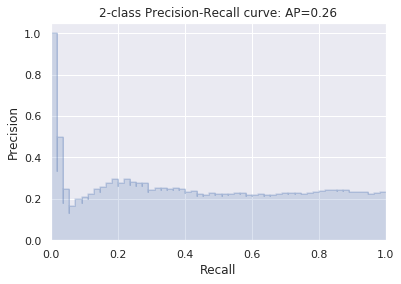

In [37]:
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [22]:
# dfr
for clf_name, result in results.items():
    train_acc = np.mean([x[0] for x in result])
    test_acc = np.mean([x[1] for x in result])
    print("{:10s} | Train: {:.3f}, Test: {:.3f}".format(clf_name, train_acc, test_acc))

RF         | Train: 0.683, Test: 0.545
LogReg     | Train: 0.723, Test: 0.531
SVM        | Train: 0.748, Test: 0.528
MLP        | Train: 0.768, Test: 0.540


In [46]:
# lica
for clf_name, result in results.items():
    train_acc = np.mean([x[0] for x in result])
    test_acc = np.mean([x[1] for x in result])
    print("{:10s} | Train: {:.3f}, Test: {:.3f}".format(clf_name, train_acc, test_acc))

RF         | Train: 0.694, Test: 0.524
LogReg     | Train: 0.732, Test: 0.500
SVM        | Train: 0.746, Test: 0.514
MLP        | Train: 0.771, Test: 0.496
